In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_bids

from wordfreq import zipf_frequency

In [3]:
ROOT = Path("../data/MASC-MEG")

In [4]:
bids_path = mne_bids.BIDSPath(
    subject='12', 
    session='0', 
    task='0',
    datatype="meg",
    root=ROOT
)

In [5]:
bids_path

BIDSPath(
root: ../data/MASC-MEG
datatype: meg
basename: sub-12_ses-0_task-0)

In [6]:
raw = mne_bids.read_raw_bids(bids_path).load_data().filter(0.5, 30.0, n_jobs=1)

Extracting SQD Parameters from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_events.tsv.
Reading channel info from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 371999  =      0.000 ...   371.999 secs...


/tmp/ipykernel_594/24403004.py:1: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path).load_data().filter(0.5, 30.0, n_jobs=1)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 sec)



## MEG data specs

**Shape**:

- 256 channels (208 + 16 refs + 32 misc)
- 372000 time points (1000 Hz * 6min 12sec)

**Channels**

- 1-224: MEG (001 - 224)
- 225-256: Misc (001 - 016)

In [7]:
raw.get_data().shape

(256, 372000)

In [8]:
raw

<RawKIT | sub-12_ses-0_task-0_meg.con, 256 x 372000 (372.0 s), ~726.8 MB, data loaded>

In [9]:
raw.ch_names

['MEG 001',
 'MEG 002',
 'MEG 003',
 'MEG 004',
 'MEG 005',
 'MEG 006',
 'MEG 007',
 'MEG 008',
 'MEG 009',
 'MEG 010',
 'MEG 011',
 'MEG 012',
 'MEG 013',
 'MEG 014',
 'MEG 015',
 'MEG 016',
 'MEG 017',
 'MEG 018',
 'MEG 019',
 'MEG 020',
 'MEG 021',
 'MEG 022',
 'MEG 023',
 'MEG 024',
 'MEG 025',
 'MEG 026',
 'MEG 027',
 'MEG 028',
 'MEG 029',
 'MEG 030',
 'MEG 031',
 'MEG 032',
 'MEG 033',
 'MEG 034',
 'MEG 035',
 'MEG 036',
 'MEG 037',
 'MEG 038',
 'MEG 039',
 'MEG 040',
 'MEG 041',
 'MEG 042',
 'MEG 043',
 'MEG 044',
 'MEG 045',
 'MEG 046',
 'MEG 047',
 'MEG 048',
 'MEG 049',
 'MEG 050',
 'MEG 051',
 'MEG 052',
 'MEG 053',
 'MEG 054',
 'MEG 055',
 'MEG 056',
 'MEG 057',
 'MEG 058',
 'MEG 059',
 'MEG 060',
 'MEG 061',
 'MEG 062',
 'MEG 063',
 'MEG 064',
 'MEG 065',
 'MEG 066',
 'MEG 067',
 'MEG 068',
 'MEG 069',
 'MEG 070',
 'MEG 071',
 'MEG 072',
 'MEG 073',
 'MEG 074',
 'MEG 075',
 'MEG 076',
 'MEG 077',
 'MEG 078',
 'MEG 079',
 'MEG 080',
 'MEG 081',
 'MEG 082',
 'MEG 083',
 'ME

## Annotations data specs

- onset: time stamp (from beginning of signal)
- duration: end - start (s)
- start: start of onset wrt to beginning of story

3 types of annotations:

- sound: beginning of task (sound_id: 0 to 3)
- word: word level annotation
- phoneme: phoneme level annotation (word info is obtained using ffill to fill NA values)

**Notes**:

- Get onsets from `raw.annotations` object, otherwise they are forced into an unconvenient datetime object
- Sound annotations always precede all annotations.
- Word annotations always follow the first phoneme annotation of each word.

In [10]:
df_raw = raw.annotations.to_data_frame()

In [11]:
df_raw["onset"] = raw.annotations.onset

In [12]:
df_raw.head()

,onset,duration,description
0,15.473,0.00,"{'index': 23.0, 'subject': 'A0255', 'story': '..."
1,15.473,0.08,"{'story': 'lw1', 'story_uid': 0.0, 'sound_id':..."
2,15.473,0.30,"{'story': 'lw1', 'story_uid': 0.0, 'sound_id':..."
3,15.553,0.09,"{'story': 'lw1', 'story_uid': 0.0, 'sound_id':..."
4,15.643,0.07,"{'story': 'lw1', 'story_uid': 0.0, 'sound_id':..."


In [13]:
df_desc = pd.DataFrame(df_raw.description.apply(eval).to_list())

In [14]:
df_desc.head()

,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
0,23.0,A0255,lw1,0.0,0.0,sound,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,t_B,0.0,sentence,0.0,205.0,Allison,1.0,NaN
2,NaN,NaN,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,0.0,205.0,Allison,1.0,Tara
3,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.08,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN
4,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.17,stimuli/audio/lw1_0.wav,r_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN


In [15]:
df = pd.concat([df_raw.drop("description", axis=1), df_desc], axis=1)

In [16]:
df.head()

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
0,15.473,0.00,23.0,A0255,lw1,0.0,0.0,sound,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.473,0.08,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,t_B,0.0,sentence,0.0,205.0,Allison,1.0,NaN
2,15.473,0.30,NaN,NaN,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,0.0,205.0,Allison,1.0,Tara
3,15.553,0.09,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.08,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN
4,15.643,0.07,NaN,NaN,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.17,stimuli/audio/lw1_0.wav,r_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN


In [17]:
df.kind.unique()

array(['sound', 'phoneme', 'word'], dtype=object)

In [18]:
seq_mark = df.query("kind=='sound'")
seq_mark

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
0,15.473,0.0,23.0,A0255,lw1,0.0,0.0,sound,A0255_MASC_2_30Mar17_01.con,0.0,stimuli/audio/lw1_0.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,122.818,0.0,25.0,A0255,lw1,0.0,1.0,sound,A0255_MASC_2_30Mar17_01.con,0.0,stimuli/audio/lw1_1.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1527,203.148,0.0,27.0,A0255,lw1,0.0,2.0,sound,A0255_MASC_2_30Mar17_01.con,0.0,stimuli/audio/lw1_2.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2551,303.126,0.0,29.0,A0255,lw1,0.0,3.0,sound,A0255_MASC_2_30Mar17_01.con,0.0,stimuli/audio/lw1_3.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df[["index", "subject"]] = df[["index", "subject"]].fillna(method="ffill")

In [20]:
df.head()

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
0,15.473,0.00,23.0,A0255,lw1,0.0,0.0,sound,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.473,0.08,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,t_B,0.0,sentence,0.0,205.0,Allison,1.0,NaN
2,15.473,0.30,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,0.0,205.0,Allison,1.0,Tara
3,15.553,0.09,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.08,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN
4,15.643,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.17,stimuli/audio/lw1_0.wav,r_I,0.0,sentence,0.0,205.0,Allison,1.0,NaN


In [21]:
df_ = df.copy().query("kind != 'sound'")
df_["word"] = df_["word"].shift(-1)
df_filled = df_["word"].fillna(method="ffill")

In [22]:
df.loc[df["kind"] != "sound", "word"] = df_filled

In [23]:
df.head(20)

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
0,15.473,0.00,23.0,A0255,lw1,0.0,0.0,sound,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.0.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.473,0.08,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,t_B,0.0,sentence,0.0,205.0,Allison,1.0,Tara
2,15.473,0.30,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,0.0,205.0,Allison,1.0,Tara
3,15.553,0.09,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.08,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,Tara
4,15.643,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.17,stimuli/audio/lw1_0.wav,r_I,0.0,sentence,0.0,205.0,Allison,1.0,Tara
5,15.713,0.06,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.24,stimuli/audio/lw1_0.wav,ah_E,0.0,sentence,0.0,205.0,Allison,1.0,Tara
6,15.783,0.06,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.31,stimuli/audio/lw1_0.wav,s_B,0.0,sentence,1.0,205.0,Allison,1.0,stood
7,15.783,0.24,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.31,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,1.0,205.0,Allison,1.0,stood
8,15.843,0.04,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.37,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,1.0,205.0,Allison,1.0,stood
9,15.883,0.08,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.41,stimuli/audio/lw1_0.wav,uh_I,0.0,sentence,1.0,205.0,Allison,1.0,stood


In [24]:
df_ph = df.query("kind=='phoneme'")
df_w  = df.query("kind=='word'")

In [25]:
df_ph.head(10)

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word
1,15.473,0.08,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.00,stimuli/audio/lw1_0.wav,t_B,0.0,sentence,0.0,205.0,Allison,1.0,Tara
3,15.553,0.09,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.08,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,Tara
4,15.643,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.17,stimuli/audio/lw1_0.wav,r_I,0.0,sentence,0.0,205.0,Allison,1.0,Tara
5,15.713,0.06,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.24,stimuli/audio/lw1_0.wav,ah_E,0.0,sentence,0.0,205.0,Allison,1.0,Tara
6,15.783,0.06,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.31,stimuli/audio/lw1_0.wav,s_B,0.0,sentence,1.0,205.0,Allison,1.0,stood
8,15.843,0.04,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.37,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,1.0,205.0,Allison,1.0,stood
9,15.883,0.08,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.41,stimuli/audio/lw1_0.wav,uh_I,0.0,sentence,1.0,205.0,Allison,1.0,stood
10,15.963,0.06,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.49,stimuli/audio/lw1_0.wav,d_E,0.0,sentence,1.0,205.0,Allison,1.0,stood
11,16.023,0.05,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.55,stimuli/audio/lw1_0.wav,s_B,0.0,sentence,2.0,205.0,Allison,1.0,stock
13,16.073,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.60,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,2.0,205.0,Allison,1.0,stock


In [26]:
ph_info = pd.read_csv(ROOT / "phoneme_info.csv")
subjects = pd.read_csv(ROOT / "participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values

In [27]:
len(subjects)

27

## Phoneme infos

- Code
- Phonation (voiced: v, unvoiced: uv, silent: s)
- Articulatory parameters

In [28]:
ph_info.head()

,phoneme,phonation,manner,place,frontback,roundness,centrality
0,aa,v,v,lo,b,u,c
1,ae,v,v,lo,f,u,f
2,ah,v,v,lo,f,u,f
3,ao,v,v,m,b,r,f
4,aw,v,v,m,b,r,f


In [29]:
ph_info.phonation.unique()

array(['v', 'uv', 's'], dtype=object)

In [30]:
ph_info.manner.unique()

array(['v', 'o', 'f', 'a', 'n', 's'], dtype=object)

Coarticulation is taken into account?

In [31]:
ph_info.phoneme.unique()

array(['aa', 'ae', 'ah', 'ao', 'aw', 'ax-h', 'ax', 'axr', 'ay', 'b',
       'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 'em', 'en', 'eng',
       'er', 'ey', 'f', 'g', 'gcl', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh',
       'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pcl', 'q',
       'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 'ux', 'v', 'w', 'y',
       'z', 'zh', 'sil', 'h#', 'epi', 'pau'], dtype=object)

## Code from https://github.com/kingjr/meg-masc

In [32]:
# ALREADY DONE ABOVE
# meta = df
# meta = list()
# for annot in raw.annotations:
#     d = eval(annot.pop("description"))
#     for k, v in annot.items():
#         assert k not in d.keys()
#         d[k] = v
#     meta.append(d)
# meta = pd.DataFrame(meta)
# meta["intercept"] = 1.0

In [34]:
# compute voicing
assert len(df_ph)
for ph, d in df_ph.groupby("phoneme"):
    ph = ph.split("_")[0]
    match = ph_info.query("phoneme==@ph")
    assert len(match) == 1
    df.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

In [35]:
df[["kind", "onset", "phoneme", "voiced"]].head(10)

,kind,onset,phoneme,voiced
0,sound,15.473,NaN,NaN
1,phoneme,15.473,t_B,False
2,word,15.473,NaN,NaN
3,phoneme,15.553,eh_I,True
4,phoneme,15.643,r_I,True
5,phoneme,15.713,ah_E,True
6,phoneme,15.783,s_B,False
7,word,15.783,NaN,NaN
8,phoneme,15.843,t_I,False
9,phoneme,15.883,uh_I,True


In [36]:
words = df.query('kind=="word"').copy()
words

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word,voiced
2,15.473,0.30,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.000000,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,0.0,205.0,Allison,1.0,Tara,NaN
7,15.783,0.24,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.310000,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,1.0,205.0,Allison,1.0,stood,NaN
12,16.023,0.37,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,0.550000,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,2.0,205.0,Allison,1.0,stock,NaN
17,16.553,0.40,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,1.080000,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,3.0,205.0,Allison,1.0,still,NaN
22,17.103,0.41,23.0,A0255,lw1,0.0,0.0,word,A0255_MASC_2_30Mar17_01.con,1.630000,stimuli/audio/lw1_0.wav,NaN,0.0,sentence,4.0,205.0,Allison,1.0,waiting,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,353.196,0.17,29.0,A0255,lw1,0.0,3.0,word,A0255_MASC_2_30Mar17_01.con,50.070000,stimuli/audio/lw1_3.wav,NaN,52.0,sentence,15.0,205.0,Allison,1.0,end,NaN
3113,353.376,0.14,29.0,A0255,lw1,0.0,3.0,word,A0255_MASC_2_30Mar17_01.con,50.250000,stimuli/audio/lw1_3.wav,NaN,52.0,sentence,16.0,205.0,Allison,1.0,for,NaN
3116,353.586,0.58,29.0,A0255,lw1,0.0,3.0,word,A0255_MASC_2_30Mar17_01.con,50.460000,stimuli/audio/lw1_3.wav,NaN,52.0,sentence,18.0,205.0,Allison,1.0,project,NaN
3124,354.306,0.15,29.0,A0255,lw1,0.0,3.0,word,A0255_MASC_2_30Mar17_01.con,51.179999,stimuli/audio/lw1_3.wav,NaN,52.0,sentence,19.0,205.0,Allison,1.0,and,NaN


In [37]:
df.loc[words.index + 1]

,onset,duration,index,subject,story,story_uid,sound_id,kind,meg_file,start,sound,phoneme,sequence_id,condition,word_index,speech_rate,voice,pronounced,word,voiced
3,15.553,0.09,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.080000,stimuli/audio/lw1_0.wav,eh_I,0.0,sentence,0.0,205.0,Allison,1.0,Tara,True
8,15.843,0.04,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.370000,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,1.0,205.0,Allison,1.0,stood,False
13,16.073,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,0.600000,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,2.0,205.0,Allison,1.0,stock,False
18,16.633,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,1.160000,stimuli/audio/lw1_0.wav,t_I,0.0,sentence,3.0,205.0,Allison,1.0,still,False
23,17.243,0.07,23.0,A0255,lw1,0.0,0.0,phoneme,A0255_MASC_2_30Mar17_01.con,1.770000,stimuli/audio/lw1_0.wav,ey_I,0.0,sentence,4.0,205.0,Allison,1.0,waiting,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,353.256,0.05,29.0,A0255,lw1,0.0,3.0,phoneme,A0255_MASC_2_30Mar17_01.con,50.130000,stimuli/audio/lw1_3.wav,n_I,52.0,sentence,15.0,205.0,Allison,1.0,end,True
3114,353.446,0.07,29.0,A0255,lw1,0.0,3.0,phoneme,A0255_MASC_2_30Mar17_01.con,50.320000,stimuli/audio/lw1_3.wav,er_E,52.0,sentence,16.0,205.0,Allison,1.0,for,True
3117,353.646,0.05,29.0,A0255,lw1,0.0,3.0,phoneme,A0255_MASC_2_30Mar17_01.con,50.520000,stimuli/audio/lw1_3.wav,r_I,52.0,sentence,18.0,205.0,Allison,1.0,project,True
3125,354.376,0.04,29.0,A0255,lw1,0.0,3.0,phoneme,A0255_MASC_2_30Mar17_01.con,51.249999,stimuli/audio/lw1_3.wav,n_I,52.0,sentence,19.0,205.0,Allison,1.0,and,True


In [38]:
X = raw.get_data()

In [35]:
_ = raw.plot(start=15.553, duration=3, butterfly=True, events=df.onset.values)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [116]:
# why is index shifted by +1 ??

# compute word frquency and merge w/ phoneme
meta["is_word"] = False
words = meta.query('kind=="word"').copy()
assert len(words) > 10
# assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
meta.loc[words.index + 1, "is_word"] = True
wfreq = lambda x: zipf_frequency(x, "en")  # noqa
meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

In [126]:
meta[["kind", "onset", "duration", "phoneme", "word", "is_word", "wordfreq"]]

,kind,onset,duration,phoneme,word,is_word,wordfreq
0,sound,15.473,0.00,NaN,NaN,False,NaN
1,phoneme,15.473,0.08,t_B,NaN,False,NaN
2,word,15.473,0.30,NaN,Tara,False,NaN
3,phoneme,15.553,0.09,eh_I,NaN,True,3.66
4,phoneme,15.643,0.07,r_I,NaN,False,NaN
...,...,...,...,...,...,...,...
3129,phoneme,354.976,0.09,p_I,NaN,True,4.85
3130,phoneme,355.066,0.09,iy_I,NaN,False,NaN
3131,phoneme,355.156,0.08,sh_I,NaN,False,NaN
3132,phoneme,355.236,0.01,iy_I,NaN,False,NaN


In [60]:
events = np.c_[
    meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
].astype(int)

In [61]:
meta.onset * raw.info["sfreq"]

0        15473.0
1        15473.0
2        15473.0
3        15553.0
4        15643.0
          ...   
3129    354976.0
3130    355066.0
3131    355156.0
3132    355236.0
3133    355246.0
Name: onset, Length: 3134, dtype: float64

In [57]:
events

array([[ 15473,      1,      1],
       [ 15473,      1,      1],
       [ 15473,      1,      1],
       ...,
       [355156,      1,      1],
       [355236,      1,      1],
       [355246,      1,      1]])

In [127]:
# preproc annotations
from wordfreq import zipf_frequency
meta = list()
for annot in raw.annotations:
    d = eval(annot.pop("description"))
    for k, v in annot.items():
        assert k not in d.keys()
        d[k] = v
    meta.append(d)
meta = pd.DataFrame(meta)
meta["intercept"] = 1.0

# compute voicing
phonemes = meta.query('kind=="phoneme"')
assert len(phonemes)
for ph, d in phonemes.groupby("phoneme"):
    ph = ph.split("_")[0]
    match = ph_info.query("phoneme==@ph")
    assert len(match) == 1
    meta.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

# compute word frquency and merge w/ phoneme
meta["is_word"] = False
words = meta.query('kind=="word"').copy()
assert len(words) > 10
# assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
meta.loc[words.index + 1, "is_word"] = True
wfreq = lambda x: zipf_frequency(x, "en")  # noqa
meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

meta = meta.query('kind=="phoneme"')
assert len(meta.wordfreq.unique()) > 2

# segment
events = np.c_[
    meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
].astype(int)

epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=3,
    decim=10,
    baseline=(-0.2, 0.0),
    metadata=meta,
    preload=True,
    event_repeated="drop",
)

# threshold
th = np.percentile(np.abs(epochs._data), 95)
epochs._data[:] = np.clip(epochs._data, -th, th)
epochs.apply_baseline()
th = np.percentile(np.abs(epochs._data), 95)
epochs._data[:] = np.clip(epochs._data, -th, th)
epochs.apply_baseline()

Adding metadata with 24 columns
2462 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2462 events and 3201 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Number of events,2462
Events,1: 2462
Time range,-0.200 – 3.000 sec
Baseline,-0.200 – 0.000 sec


In [130]:
epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(epochs))
            ).astype(int)
epochs.metadata["task"] = '0'
epochs.metadata["session"] = '0'

In [153]:
words = epochs["not is_word"]
X = words.get_data() * 1e13

In [156]:
words.to_data_frame()

,time,condition,epoch,MEG 001,MEG 002,MEG 003,MEG 004,MEG 005,MEG 006,MEG 007,...,MISC 023,MISC 024,MISC 025,MISC 026,MISC 027,MISC 028,MISC 029,MISC 030,MISC 031,MISC 032
0,-0.20,1,0,39.323470,31.688050,-61.896060,-21.580210,14.665444,-132.529171,-81.409537,...,-0.005035,-0.005493,-0.005035,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000305
1,-0.19,1,0,-65.299755,-13.962312,-33.712135,65.253150,71.977833,-52.853037,-65.227334,...,-0.005341,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
2,-0.18,1,0,-29.446746,-11.694765,42.991072,165.418351,73.480266,-120.001943,-42.962757,...,-0.005646,-0.005493,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000916
3,-0.17,1,0,88.426260,45.253128,57.105984,139.026104,15.452529,-75.860990,-44.824451,...,-0.005188,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
4,-0.16,1,0,23.372036,76.288306,48.660583,128.882344,64.294311,117.257598,-77.230691,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575869,2.96,1,2461,-113.184038,-186.104181,-64.872201,-162.498523,-126.650310,-107.860325,100.503101,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458
575870,2.97,1,2461,-84.969394,-112.525192,8.549151,-84.517223,-26.121324,-28.079162,74.500401,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
575871,2.98,1,2461,93.040427,29.434764,121.278664,-47.186059,80.263582,147.272359,115.899236,...,-0.005493,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458
575872,2.99,1,2461,148.021168,79.340376,137.083223,-32.240070,75.785131,139.929058,131.872863,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458


In [135]:
epochs

,time,condition,epoch,MEG 001,MEG 002,MEG 003,MEG 004,MEG 005,MEG 006,MEG 007,...,MISC 023,MISC 024,MISC 025,MISC 026,MISC 027,MISC 028,MISC 029,MISC 030,MISC 031,MISC 032
0,-0.20,1,0,39.323470,31.688050,-61.896060,-21.580210,14.665444,-132.529171,-81.409537,...,-0.005035,-0.005493,-0.005035,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000305
1,-0.19,1,0,-65.299755,-13.962312,-33.712135,65.253150,71.977833,-52.853037,-65.227334,...,-0.005341,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
2,-0.18,1,0,-29.446746,-11.694765,42.991072,165.418351,73.480266,-120.001943,-42.962757,...,-0.005646,-0.005493,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000916
3,-0.17,1,0,88.426260,45.253128,57.105984,139.026104,15.452529,-75.860990,-44.824451,...,-0.005188,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
4,-0.16,1,0,23.372036,76.288306,48.660583,128.882344,64.294311,117.257598,-77.230691,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790297,2.96,1,2461,-113.184038,-186.104181,-64.872201,-162.498523,-126.650310,-107.860325,100.503101,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458
790298,2.97,1,2461,-84.969394,-112.525192,8.549151,-84.517223,-26.121324,-28.079162,74.500401,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000000
790299,2.98,1,2461,93.040427,29.434764,121.278664,-47.186059,80.263582,147.272359,115.899236,...,-0.005493,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458
790300,2.99,1,2461,148.021168,79.340376,137.083223,-32.240070,75.785131,139.929058,131.872863,...,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,-0.005646,0.005646,0.000458


In [132]:
X.shape

(668, 256, 321)

In [138]:
epochs.annotations.description

array(["{'index': 23.0, 'subject': 'A0255', 'story': 'lw1', 'story_uid': 0.0, 'sound_id': 0.0, 'kind': 'sound', 'meg_file': 'A0255_MASC_2_30Mar17_01.con', 'start': 0.0, 'sound': 'stimuli/audio/lw1_0.0.wav'}",
       "{'story': 'lw1', 'story_uid': 0.0, 'sound_id': 0.0, 'kind': 'phoneme', 'meg_file': 'A0255_MASC_2_30Mar17_01.con', 'start': 0.0, 'sound': 'stimuli/audio/lw1_0.wav', 'phoneme': 't_B', 'sequence_id': 0.0, 'condition': 'sentence', 'word_index': 0.0, 'speech_rate': 205.0, 'voice': 'Allison', 'pronounced': 1.0}",
       "{'story': 'lw1', 'story_uid': 0.0, 'sound_id': 0.0, 'kind': 'word', 'meg_file': 'A0255_MASC_2_30Mar17_01.con', 'start': 0.0, 'sound': 'stimuli/audio/lw1_0.wav', 'word': 'Tara', 'sequence_id': 0.0, 'condition': 'sentence', 'word_index': 0.0, 'speech_rate': 205.0, 'voice': 'Allison', 'pronounced': 1.0}",
       ...,
       "{'story': 'lw1', 'story_uid': 0.0, 'sound_id': 3.0, 'kind': 'phoneme', 'meg_file': 'A0255_MASC_2_30Mar17_01.con', 'start': 52.03, 'sound': 'st

In [ ]:
meta.head()

In [ ]:
y = words.metadata["wordfreq"].values

In [ ]:
y.shape

In [ ]:
def plot(result):
    fig, ax = plt.subplots(1, figsize=[6, 6])
    sns.lineplot(x="time", y="score", data=result, hue="label", ax=ax)
    ax.axhline(0, color="k")
    return fig

In [ ]:
# Phonemes
phonemes = epochs["not is_word"]
evo = phonemes.average()
fig_evo_ph = evo.plot(spatial_colors=True, show=False)

In [ ]:
phonemes.metadata.iloc[0:50]

In [ ]:
epochs.events

In [139]:
XX = words.average()

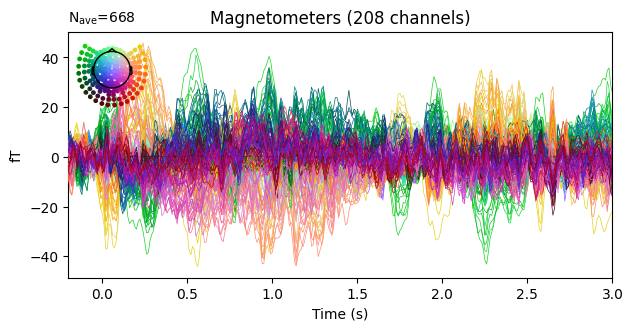

In [140]:
fig_evo_word = XX.plot(spatial_colors=True, show=False)

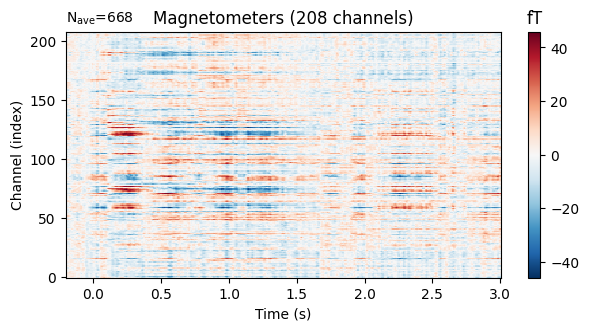

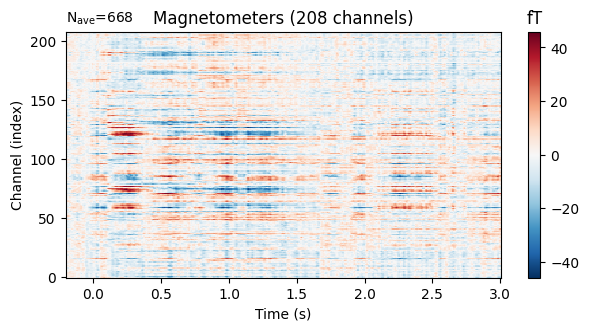

In [141]:
XX.plot_image()

    Using multitaper spectrum estimation with 7 DPSS windows


/home/nathan/Projects/MEG_ESN/venv/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


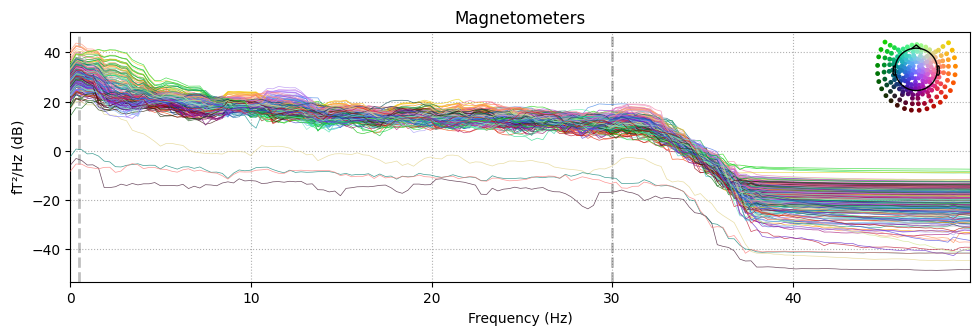

In [149]:
_ = XX.compute_psd().plot()

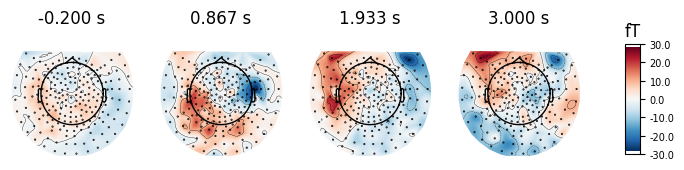

In [152]:
_ = XX.plot_topomap()

In [ ]:
select_picks = np.concatenate(
    (mne.pick_types(raw.info, meg=True)[-32:],
     #mne.pick_types(raw.info, meg=False, ref_meg=True)
    ))
plot_kwargs = dict(
    duration=360, order=select_picks, n_channels=len(select_picks),
    scalings={"mag": 8e-13, "ref_meg": 2e-11})
raw.plot(**plot_kwargs)


In [ ]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)


In [ ]:
sampling_freq

In [ ]:
raw.plot()

In [ ]:
import matplotlib.pyplot as plt
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([394, 400])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_names = ['MEG 001', 'MEG 208']
two_meg_chans = raw[channel_names, start_sample:stop_sample]
y_offset = np.array([1e-11, 0])  # just enough to separate the channel traces
x = two_meg_chans[1]
y = two_meg_chans[0].T + y_offset
lines = plt.plot(x, y)
plt.legend(lines, channel_names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from os.path import join

import mne
from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

In [ ]:
path = mne.datasets.mtrf.data_path()
decim = 2
data = loadmat(join(path, 'speech_data.mat'))
raw = data['EEG'].T
speech = data['envelope'].T
sfreq = float(data['Fs'])
sfreq /= decim
speech = mne.filter.resample(speech, down=decim, npad='auto')
raw = mne.filter.resample(raw, down=decim, npad='auto')

# Read in channel positions and create our MNE objects from the raw data
montage = mne.channels.make_standard_montage('biosemi128')
info = mne.create_info(montage.ch_names, sfreq, 'eeg').set_montage(montage)
raw = mne.io.RawArray(raw, info)
n_channels = len(raw.ch_names)

# Plot a sample of brain and stimulus activity
fig, ax = plt.subplots()
lns = ax.plot(scale(raw[:, :800][0].T), color='k', alpha=.1)
ln1 = ax.plot(scale(speech[0, :800]), color='r', lw=2)
ax.legend([lns[0], ln1[0]], ['EEG', 'Speech Envelope'], frameon=False)
ax.set(title="Sample activity", xlabel="Time (s)")
mne.viz.tight_layout()

In [ ]:
data['envelope'].T.shape

In [ ]:
data['EEG'].T.shape

In [ ]:
data.keys()

In [ ]:
data['spectrogram'].shape

In [ ]:
speech.shape

In [ ]:
info